In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
output_name = 'Griffin_ULP'
site_group = '30000-sites'

probabilities = pd.read_csv('../../delfi_downsampled_cancer_detection/number_of_sites_analysis/logreg_PCA_results/'+site_group+'_logreg_results/'+site_group+'.probabilities.txt', sep = '\t')
CI = pd.read_csv('../../delfi_downsampled_cancer_detection/number_of_sites_analysis/logreg_PCA_results/'+site_group+'_logreg_results/'+site_group+'.CI.txt', sep = '\t')
CI = CI.rename(columns = {'Unnamed: 0':'group'})
metadata = pd.read_csv('../../metadata/delfi/analysis/Delfi_tumor_fraction_data.txt', sep = '\t')
metadata = metadata[['sample','tumor_fraction','sample_type']]
probabilities = probabilities.merge(metadata, on = 'sample')
iterations = 1000
probabilities['median_probability'] = probabilities[[str(m) for m in range(iterations)]].median(axis = 1)

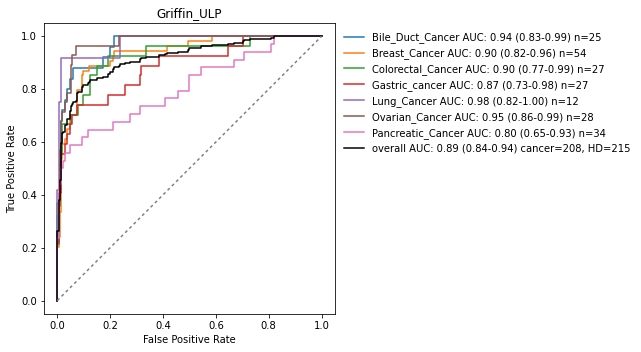

In [3]:
number_of_HD = len(probabilities[(probabilities['sample_type']=='Healthy')])

fig,ax = plt.subplots(figsize = (9.5,6))

for sample_type in probabilities['sample_type'].unique():
    if sample_type == 'Duodenal_Cancer' or sample_type == 'Healthy':#there is only one sample for Duodenal_Cancer, Healthy is included in all roc curves
        continue
    current = probabilities[(probabilities['sample_type']==sample_type) | (probabilities['sample_type']=='Healthy')]

    fpr, tpr, _ = roc_curve(current['status'].values,current['median_probability'].values)

    lower_AUC = CI[(CI['group']==sample_type)]['0.025'].values[0]
    upper_AUC = CI[(CI['group']==sample_type)]['0.975'].values[0]
    auc_val = CI[(CI['group']==sample_type)]['median'].values[0]
    
    label = sample_type+' '+\
        'AUC: '+ format(auc_val,'.2f')+' ('+format(lower_AUC, '.2f')+'-'+format(upper_AUC, '.2f')+')'+\
        ' n='+str(len(current)-number_of_HD)
    
    ax.plot(fpr,tpr, label=label)
    
    del(lower_AUC,upper_AUC,auc_val,label,fpr,tpr,current,sample_type)
#add overall AUC
fpr, tpr, _ = roc_curve(probabilities['status'].values,probabilities['median_probability'].values)

lower_AUC = CI[(CI['group']=='overall')]['0.025'].values[0]
upper_AUC = CI[(CI['group']=='overall')]['0.975'].values[0]
auc_val = CI[(CI['group']=='overall')]['median'].values[0]

label = 'overall AUC: '+ format(auc_val,'.2f')+' ('+format(lower_AUC, '.2f')+'-'+format(upper_AUC, '.2f')+') '+\
    'cancer='+str(len(probabilities)-number_of_HD)+', HD='+str(number_of_HD)

ax.plot(fpr,tpr,color='black', label = label)

ax.legend(bbox_to_anchor = [1,1],loc = 'upper left', frameon = False)

ax.plot([0,1],[0,1], color = 'grey', dashes = (2,2))

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

ax.set_title(output_name)
ax.set_aspect('equal')
fig.subplots_adjust(right=.55)

plt.savefig('plots/'+output_name+'_ROC_by_cancer_type.pdf')